# DIY Notebook: Compare KNN, Linear Regression, and Logistic Regression (Insurance Dataset)

Dataset expected: **`insurance.csv`** in the same folder as this notebook.

You will:
1) Predict medical cost (`charges`) using **Linear Regression** and **KNN Regression**.  
2) Create a binary label `high_cost` and classify it using **Logistic Regression**.  
3) Compare performance with **metrics + plots**, including combined comparison plots.

---

## DIY Tasks (3 tasks only)

### Task 1 — Data + target setup (Input → Output)
**Input:** load the dataset and define:
- `X` = features (all columns except `charges`)
- `y` = target (`charges`)

**Output:**
- Display `df.head()` and `df.dtypes`

### Task 2 — Regression models (Input → Output)
**Input:** build + train two regressors:
- Linear Regression
- KNN Regression

**Output:**
- Print MAE, RMSE, R² on test set for each
- Plot: Actual vs Predicted (each model)

### Task 3 — Classification model + combined comparisons (Input → Output)
**Input:** create `high_cost` label (1 if charges >= median else 0) and train Logistic Regression.

**Output:**
- Print Accuracy, Precision, Recall, F1, ROC-AUC
- Plot ROC curve + confusion matrix
- Combined plots:
  - Regression metric bar chart
  - Overlay plot of predictions on test samples

---

> Tip: KNN is sensitive to scaling, so we standardize numeric features inside a pipeline.


## 0) Imports (minimal)

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,4)

## 1) Load data (Task 1)
Expected file: `insurance.csv`

In [2]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

### Split features/target (Task 1 output variables)
- `X`: all columns except `charges`
- `y`: charges

In [4]:
X = df.drop(columns=['charges'])
y = df['charges']
(X.shape, y.shape)

((1338, 6), (1338,))

## 2) Train/test split

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)
(X_train.shape, X_test.shape)

((1003, 6), (335, 6))

## 3) Preprocessing (one-hot for categoricals, scaling for numeric)
We reuse the same preprocessing across models for a fair comparison.

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
num_cols = X.select_dtypes(include=['number']).columns; cat_cols = X.select_dtypes(exclude=['number']).columns

In [7]:
pre = ColumnTransformer([('num', StandardScaler(), num_cols), ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)])
(list(num_cols), list(cat_cols))

(['age', 'bmi', 'children'], ['sex', 'smoker', 'region'])

## 4) Regression Model 1: Linear Regression (Task 2)

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
lin_reg = Pipeline([('pre', pre), ('model', LinearRegression())]).fit(X_train, y_train)

In [9]:
pred_lin = lin_reg.predict(X_test)
pred_lin[:5]

array([ 8952.20855705,  7053.79716786, 36888.36911226,  9522.49758674,
       26961.84638217])

## 5) Regression Model 2: KNN Regression (Task 2)
KNN works best with scaled numeric features (handled by the pipeline).

In [10]:
from sklearn.neighbors import KNeighborsRegressor
knn_reg = Pipeline([('pre', pre), ('model', KNeighborsRegressor(n_neighbors=7, metric='euclidean'))]).fit(X_train, y_train)

In [11]:
pred_knn = knn_reg.predict(X_test)
pred_knn[:5]

array([ 9029.25469286,  6233.31224286, 24144.75299571, 11956.29365571,
       23140.59353286])

## 6) Regression metrics (Task 2 output)
MAE, RMSE, and R² for both models on the same test split.

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
rmse = lambda yt, yp: np.sqrt(mean_squared_error(yt, yp))
metrics_reg = pd.DataFrame({
    'MAE':[mean_absolute_error(y_test,pred_lin), mean_absolute_error(y_test,pred_knn)],
    'RMSE':[rmse(y_test,pred_lin), rmse(y_test,pred_knn)],
    'R2':[r2_score(y_test,pred_lin), r2_score(y_test,pred_knn)]
}, index=['LinearReg','KNNReg'])
metrics_reg

,MAE,RMSE,R2
LinearReg,4243.654117,5926.023602,0.767264
KNNReg,3617.001845,5976.212578,0.763305


## 7) Plot (individual): Actual vs Predicted — Linear Regression

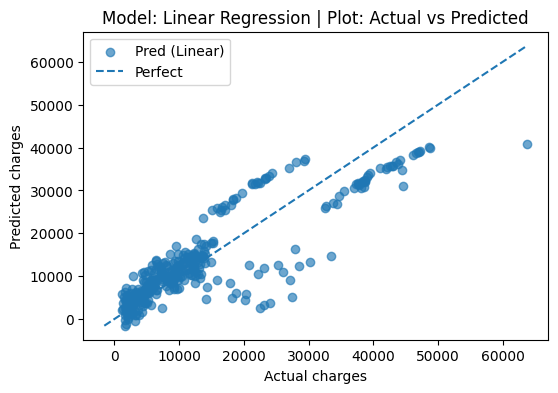

In [13]:
plt.scatter(y_test, pred_lin, alpha=0.65, label='Pred (Linear)')
m, M = float(np.min([y_test.min(), pred_lin.min()])), float(np.max([y_test.max(), pred_lin.max()]))
plt.plot([m,M],[m,M], '--', label='Perfect')
plt.xlabel('Actual charges'); plt.ylabel('Predicted charges')
plt.title('Model: Linear Regression | Plot: Actual vs Predicted')
plt.legend(); plt.show()

## 8) Plot (individual): Actual vs Predicted — KNN Regression

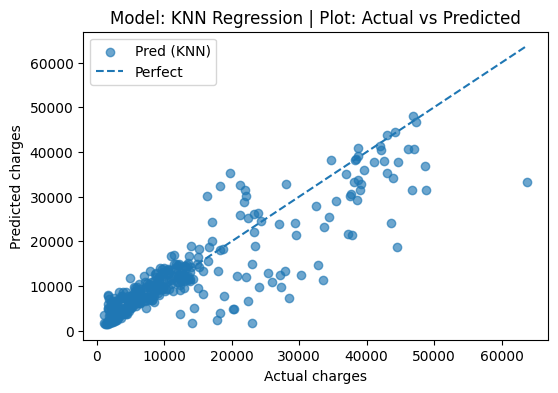

In [14]:
plt.scatter(y_test, pred_knn, alpha=0.65, label='Pred (KNN)')
m, M = float(np.min([y_test.min(), pred_knn.min()])), float(np.max([y_test.max(), pred_knn.max()]))
plt.plot([m,M],[m,M], '--', label='Perfect')
plt.xlabel('Actual charges'); plt.ylabel('Predicted charges')
plt.title('Model: KNN Regression | Plot: Actual vs Predicted')
plt.legend(); plt.show()

## 8b) Comparison plot: Actual vs Predicted (Linear vs KNN on same axes)
Same x-axis (actual). Two colors show how predictions differ between models.

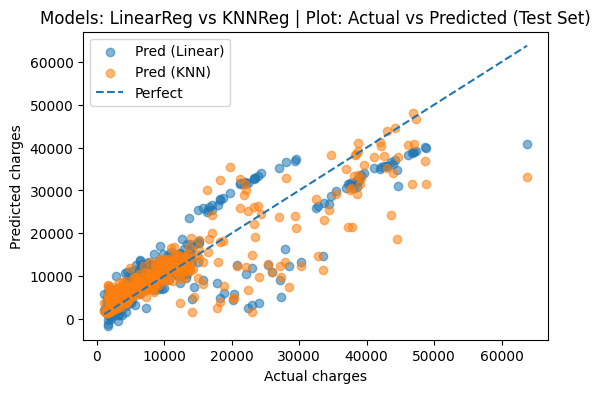

In [15]:
plt.scatter(y_test, pred_lin, alpha=0.55, label='Pred (Linear)')
plt.scatter(y_test, pred_knn, alpha=0.55, label='Pred (KNN)')
m = float(y_test.min()); M = float(y_test.max())
plt.plot([m,M],[m,M],'--', label='Perfect')
plt.xlabel('Actual charges'); plt.ylabel('Predicted charges')
plt.title('Models: LinearReg vs KNNReg | Plot: Actual vs Predicted (Test Set)')
plt.legend(); plt.show()

## 9) Create classification label (Task 3)
`high_cost = 1` if charges >= median(charges), else 0.

In [16]:
threshold = float(df['charges'].median())
yc = (y >= threshold).astype(int)
threshold

9382.033

In [17]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X,yc,test_size=0.25,random_state=42,stratify=yc)
(yc_train.mean(), yc_test.mean())

(0.5004985044865404, 0.49850746268656715)

## 10) Logistic Regression classifier (Task 3)
We use the same preprocessing pipeline.

In [18]:
from sklearn.linear_model import LogisticRegression
log_clf = Pipeline([('pre', pre), ('model', LogisticRegression(max_iter=2000))]).fit(Xc_train, yc_train)

In [19]:
prob_log = log_clf.predict_proba(Xc_test)[:,1]
pred_log = (prob_log >= 0.5).astype(int)
(pred_log[:10], prob_log[:3])

(array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1]),
 array([0.31187396, 0.01105479, 0.05176868]))

## 11) Classification metrics (Task 3 output)

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
metrics_cls = {'accuracy':accuracy_score(yc_test,pred_log), 'precision':precision_score(yc_test,pred_log), 'recall':recall_score(yc_test,pred_log), 'f1':f1_score(yc_test,pred_log), 'roc_auc':roc_auc_score(yc_test, prob_log)}
pd.Series(metrics_cls)

accuracy     0.907463
precision    0.895349
recall       0.922156
f1           0.908555
roc_auc      0.944112
dtype: float64

## 12) Plot (individual): ROC curve

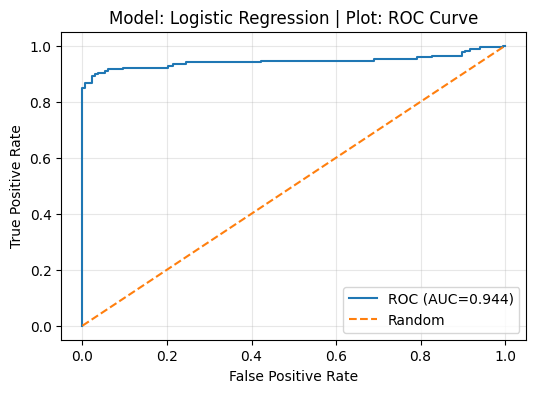

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score
auc = roc_auc_score(yc_test, prob_log)
fpr,tpr,_ = roc_curve(yc_test, prob_log)
plt.plot(fpr,tpr, label=f'ROC (AUC={auc:.3f})')
plt.plot([0,1],[0,1],'--', label='Random')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Model: Logistic Regression | Plot: ROC Curve')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

## 13) Plot (individual): Confusion matrix

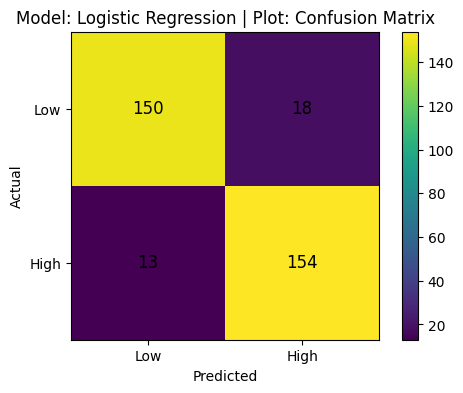

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yc_test, pred_log)
plt.imshow(cm)
plt.xticks([0,1],['Low','High']); plt.yticks([0,1],['Low','High'])
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Model: Logistic Regression | Plot: Confusion Matrix')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=12)
plt.colorbar(); plt.show()

## 14) Combined comparison plot 1: Regression metrics bar chart

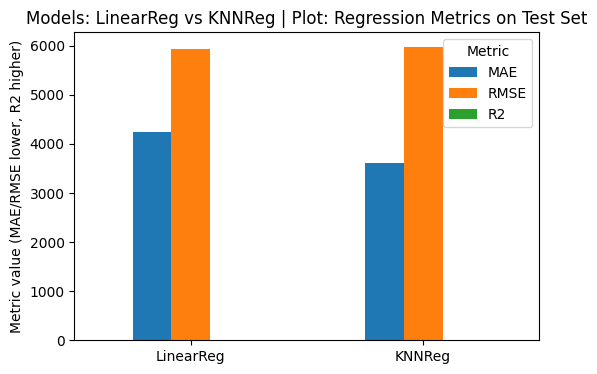

In [23]:
metrics_reg.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Models: LinearReg vs KNNReg | Plot: Regression Metrics on Test Set')
plt.ylabel('Metric value (MAE/RMSE lower, R2 higher)')
plt.legend(title='Metric'); plt.show()

## 15) Combined comparison plot 2: Overlay predictions on the same test samples
We plot the first 60 test rows (sorted by actual) to compare the *shape* of predictions.

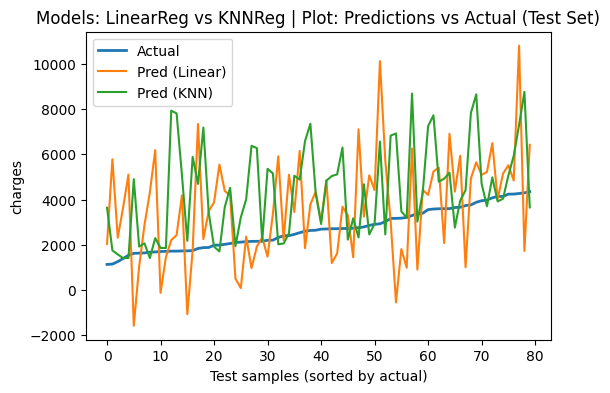

In [24]:
idx = np.argsort(y_test.to_numpy()); n=80
yt = y_test.to_numpy()[idx][:n]
pl = pred_lin[idx][:n]
pk = pred_knn[idx][:n]
x = np.arange(n)
plt.plot(x, yt, linewidth=2, label='Actual')
plt.plot(x, pl, label='Pred (Linear)')
plt.plot(x, pk, label='Pred (KNN)')
plt.xlabel('Test samples (sorted by actual)'); plt.ylabel('charges')
plt.title('Models: LinearReg vs KNNReg | Plot: Predictions vs Actual (Test Set)')
plt.legend(); plt.show()

## 15b) Combined comparison plot 3: Error vs Actual (both regression models)
This uses **target values** directly: x-axis is actual charges, y-axis is prediction error.
If one model is better, its errors will be closer to 0 across the range.

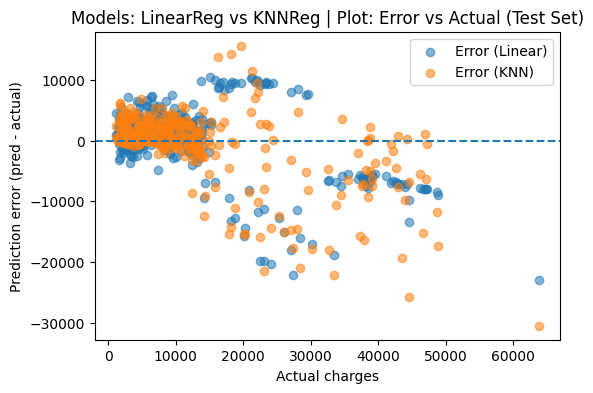

In [25]:
err_lin = pred_lin - y_test.to_numpy()
err_knn = pred_knn - y_test.to_numpy()
plt.scatter(y_test, err_lin, alpha=0.55, label='Error (Linear)')
plt.scatter(y_test, err_knn, alpha=0.55, label='Error (KNN)')
plt.axhline(0, linestyle='--')
plt.xlabel('Actual charges'); plt.ylabel('Prediction error (pred - actual)')
plt.title('Models: LinearReg vs KNNReg | Plot: Error vs Actual (Test Set)')
plt.legend(); plt.show()

## 16) Optional DIY extensions (after completing the 3 tasks)
- Change `n_neighbors` (try 3, 5, 11) and re-run.
- Try KNN distance metrics: `manhattan`, `chebyshev`.
- Change classification threshold: median → 75th percentile.
